In [43]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pandas_datareader.data as web
from datetime import datetime, date, time
from dateutil.parser import parse
from collections import defaultdict
# import random
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('ggplot')

* The work of Eyob Taffese Gebremariam was used as a starting point for this analysis

[ref: http://datacognizant.com/wp-content/uploads/2017/06/StockMarket.html](http://datacognizant.com/wp-content/uploads/2017/06/StockMarket.html)

In [445]:
# Data Download from Yahoo Finance 
##  We wanted to look at a stock that had weathered some market turbulance, 
##  so we went with Intel.
stock = "INTC"
intel = web.get_data_yahoo(stock, '2012-01-01', '2018-09-21')

In [446]:
intel.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,24.889999,24.389999,24.620001,24.540001,44845600.0,19.831244
2012-01-04,25.129999,24.530001,24.570000,25.110001,47504000.0,20.291874
2012-01-05,25.450001,24.980000,25.059999,25.400000,49490600.0,20.526220
2012-01-06,25.400000,25.010000,25.209999,25.250000,36343500.0,20.405003
2012-01-09,25.559999,25.219999,25.400000,25.469999,47478600.0,20.582792


In [447]:
intel.shape

(1692, 6)

In [448]:
## Using Adjusted market close as our analysis variable
ts = intel['Adj Close']

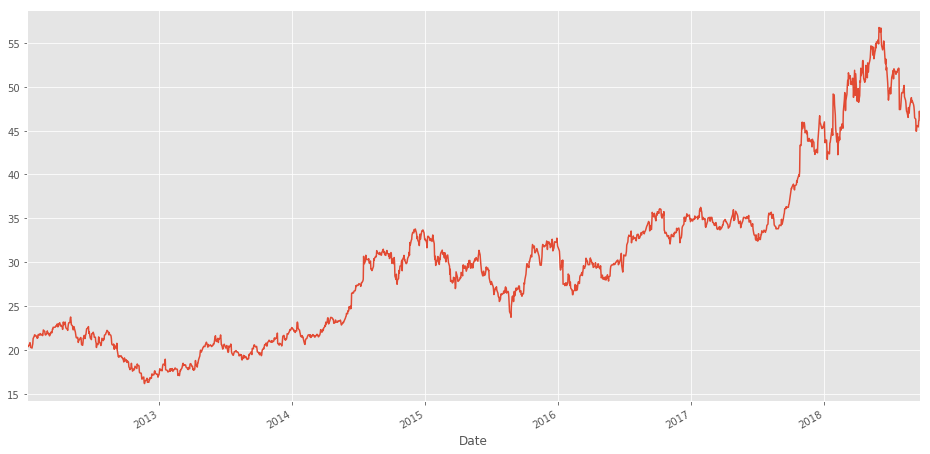

In [449]:
ts.plot(figsize=(16,8))

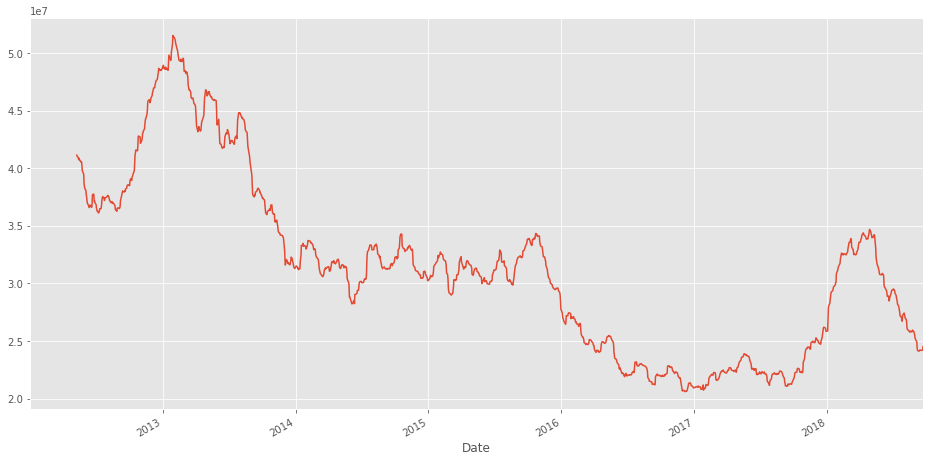

In [450]:
intel['Volume'].rolling(90).mean().plot(figsize=(16,8))

In [451]:
from statsmodels.tsa.stattools import adfuller

In [452]:
def test_stationarity(ts, window=15, x_tick_dist=40, y_tick_dist=2):
    
    ## Define Plot Object
    fig, ax = plt.subplots(1,1, figsize=(16,8))
    ax.legend(loc='best')
    ax.set_title('Rolling Mean & Standard Deviation', {'size': 24})
    ax.set_xticks(ts.index[::x_tick_dist])
    ax.set_xticklabels(ts.index[::10].date, {'rotation' : 90})
    ax.set_yticks(np.arange(int(min([0,ts.min()])), ts.max(), y_tick_dist))
    
    
    ##Determing rolling statistics
    rolmean = ts.rolling(window).mean()#.rolling_mean(timeseries, window=22)
    rolstd = ts.rolling(window).std()

    ##Plot rolling statistics:
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    ax.legend()
    plt.show(block=False)
    
    ##Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return dfoutput

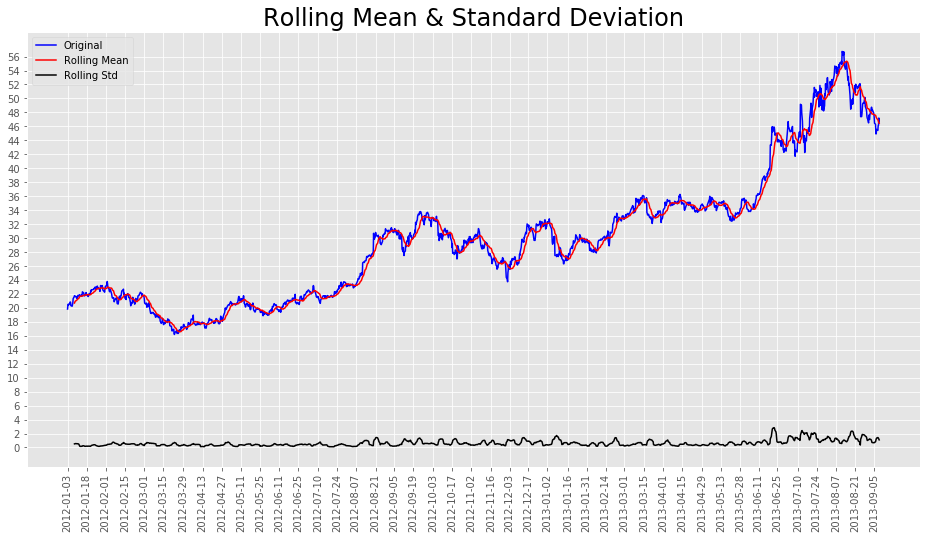

Results of Dickey-Fuller Test:
Test Statistic                   -0.359937
p-value                           0.916576
#Lags Used                        9.000000
Number of Observations Used    1682.000000
Critical Value (1%)              -3.434244
Critical Value (5%)              -2.863260
Critical Value (10%)             -2.567686
dtype: float64


In [454]:
# df_test = test_stationarity(ts[(ts.index > "2011-01-01") & (ts.index < "2018-01-01")])
df_test = test_stationarity(ts)

The data currently shows a strong degree of autocorrelation, there also appears to be an upward trend for most time periods

We cannot assume the data is stationary as is

We will now attempt to transform the timeseries into a stationary condition

In [455]:
logts = np.log(ts)

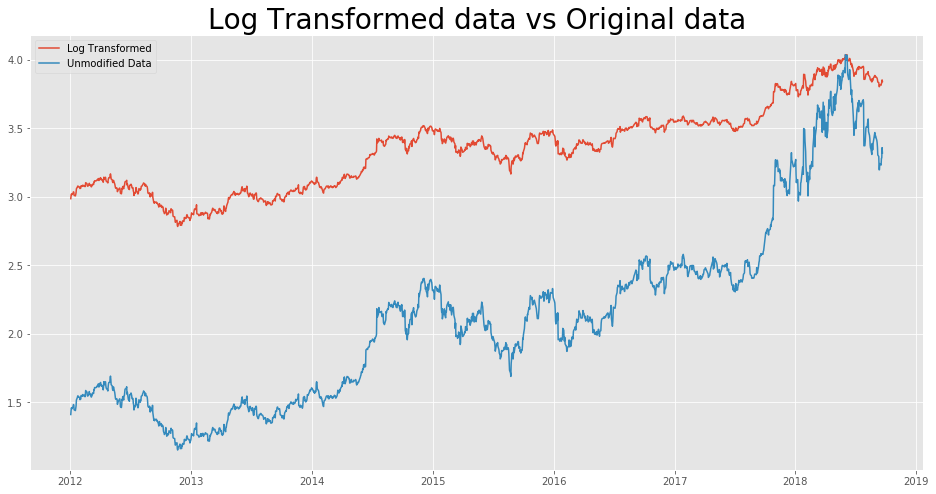

In [456]:
nts = ts / max(ts) * logts.max()
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(logts, label='Log Transformed')
ax.plot(nts, label= 'Unmodified Data')
# ax.plot(logts.rolling(15).mean(), label='Log Moving Avg')
ax.set_title("Log Transformed data vs Original data", {'size': 28})
ax.legend()

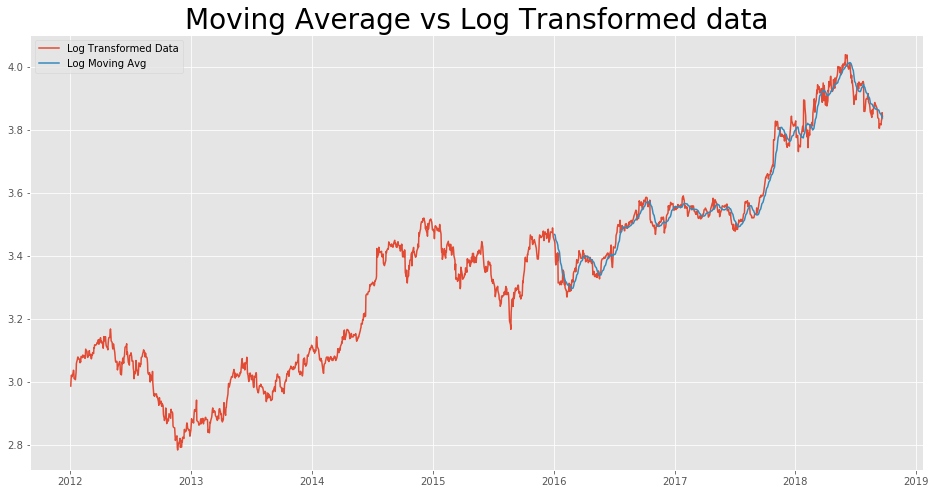

In [457]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.plot(logts, label='Log Transformed Data')
ax.plot(logts.rolling(15).mean()[logts.index > '2016-01-01'], label='Log Moving Avg')
ax.set_title("Moving Average vs Log Transformed data", {'size': 28})
ax.legend()

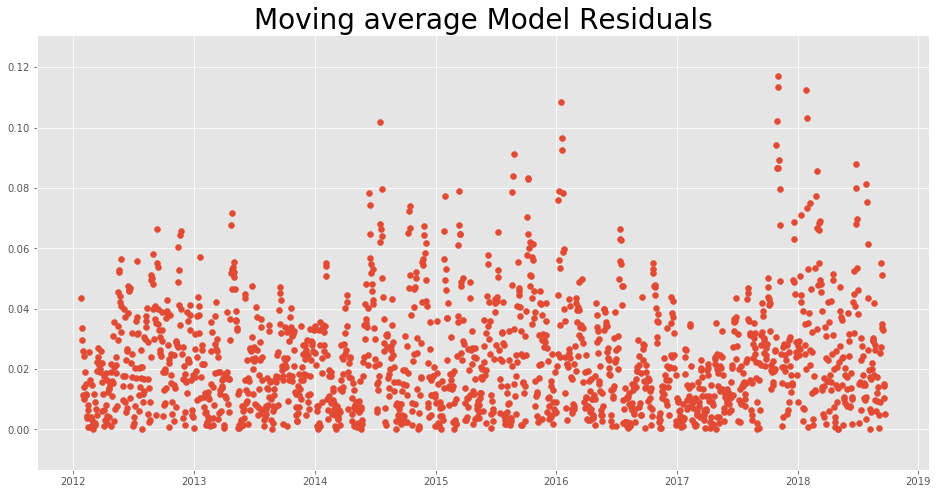

In [458]:
ma_window = 15
log_ma = logts.rolling(ma_window).mean()[ma_window:]
resids = np.sqrt((logts[ma_window:] - log_ma)**2)
fig, ax = plt.subplots(1,1, figsize=(16,8))
ax.scatter(resids.index, resids);
ax.set_title("Moving average Model Residuals", {'size': 28});

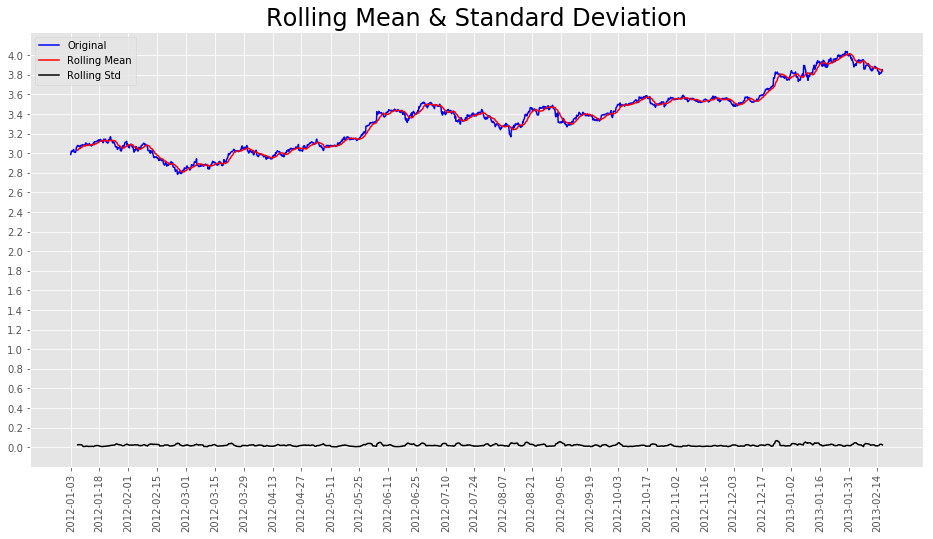

Results of Dickey-Fuller Test:
Test Statistic                   -0.574629
p-value                           0.876612
#Lags Used                        1.000000
Number of Observations Used    1690.000000
Critical Value (1%)              -3.434225
Critical Value (5%)              -2.863252
Critical Value (10%)             -2.567681
dtype: float64


In [467]:
results = test_stationarity(
                logts,
                x_tick_dist=60, y_tick_dist=.2
                )

* This is a significent improvement over the .97 p-value in the non log transformed data, but there is still a clear trend to the data, and strong evidence of autocorrelation

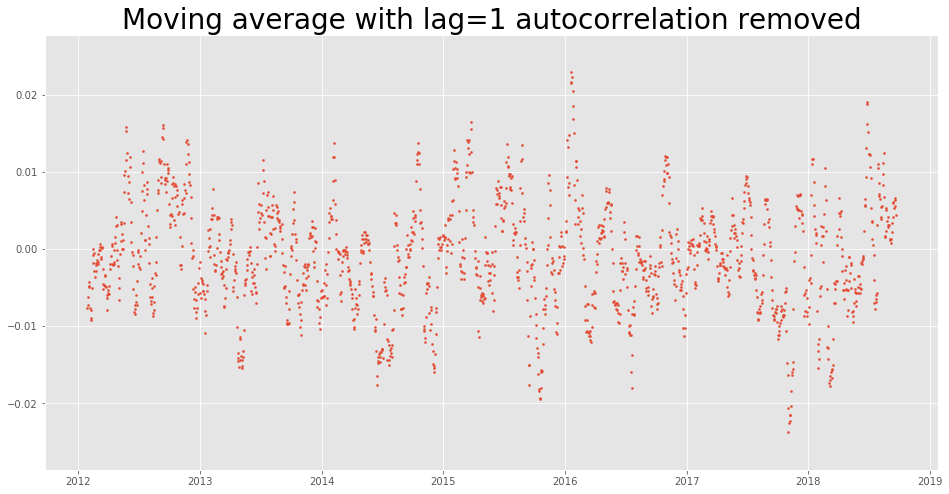

In [462]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
shift_size = 2
shifted_data = (log_ma.shift(shift_size) - log_ma)[shift_size:]
ax.scatter(shifted_data.index, shifted_data, s=4, label='Log Transformed')
ax.set_title("Moving average with lag=1 autocorrelation removed", {'size': 28})

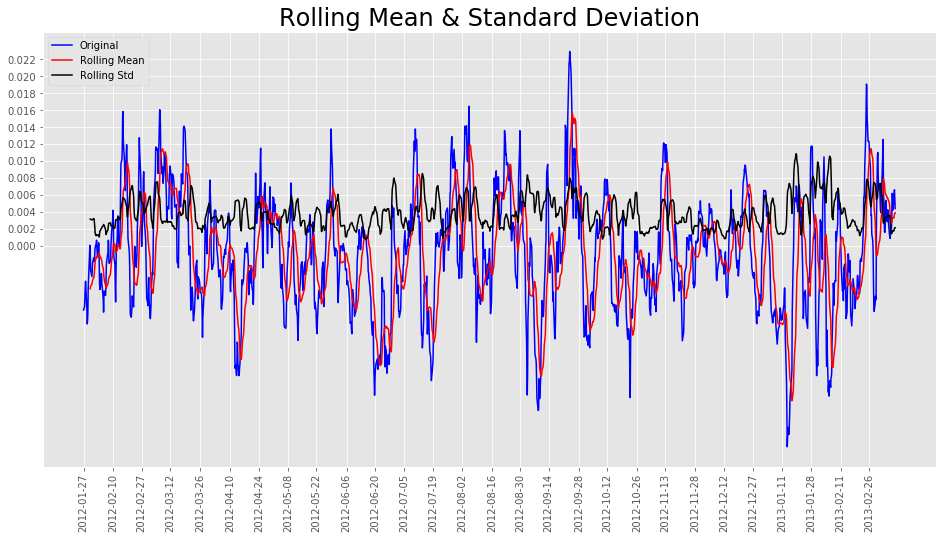

Results of Dickey-Fuller Test:
Test Statistic                -6.484692e+00
p-value                        1.269465e-08
#Lags Used                     2.100000e+01
Number of Observations Used    1.653000e+03
Critical Value (1%)           -3.434312e+00
Critical Value (5%)           -2.863290e+00
Critical Value (10%)          -2.567702e+00
dtype: float64


In [470]:
results = test_stationarity(
                shifted_data,
                x_tick_dist=60, y_tick_dist=.002
                )

By using a lag one diffirence on a moving average of the log transformed data, we have passed the Dickey-Fuller Test with a p-value of 2.9 x 10^-10, but it is worth noting, there still does seem to be some seasonality in the data.

## Decomposition

In [473]:
# seasonal_decompose(logts, model="multiplicative")

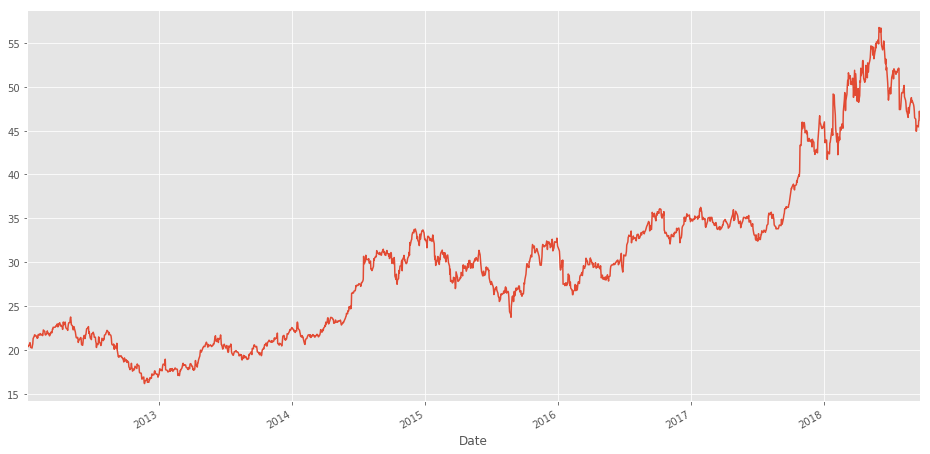

In [474]:
ts.plot(figsize=(16,8))

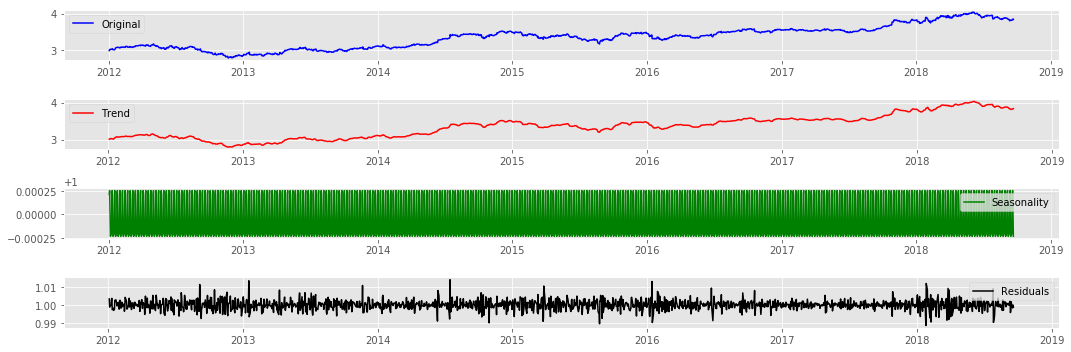

In [491]:
# Create a DataFrame with Series
slog = logts[logts.index > "1995-01-01"]

df = pd.DataFrame(slog)

# Get the time index from Series
idx = slog.index
df.set_index(idx)

# Resample using weekday frequency
df2 = df.resample('B').mean()

# Fill in missing values with interpolate
df2['Adj Close'].interpolate(inplace=True)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df2['Adj Close'], model="multiplicative")
# seasonal_decompose(logts.interpolate(inplace=True))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15, 5))
plt.style.use('ggplot')
plt.subplot(411)
plt.plot(slog, label='Original', color='b')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='r')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='g')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='k')
plt.legend(loc='best')
plt.tight_layout()

* overall there does not seem to be any seasonality in the data.  Residuals consistantly seem to spike during times where the stock has highly irregular movements, but for the most part the data seems to follow a consistant moving average trend

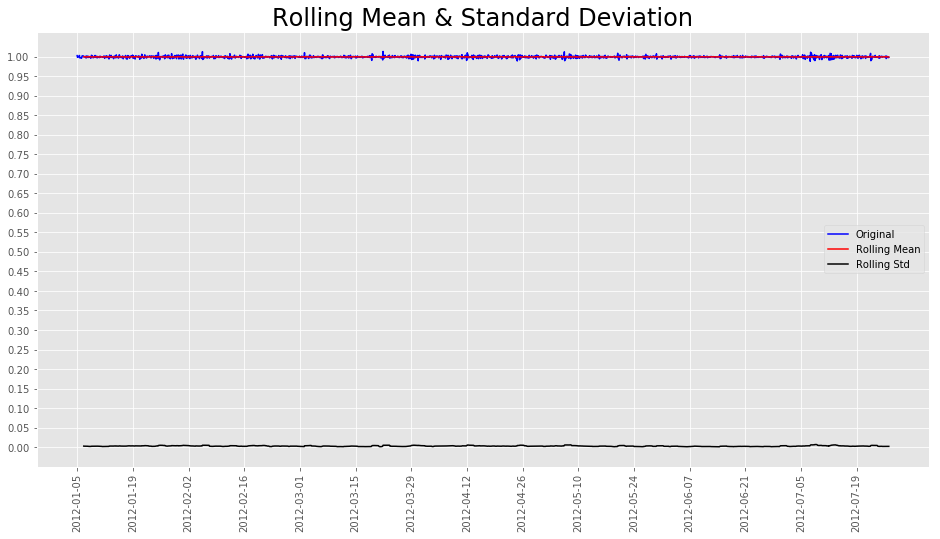

Results of Dickey-Fuller Test:
Test Statistic                -1.702652e+01
p-value                        8.384030e-30
#Lags Used                     2.000000e+01
Number of Observations Used    1.729000e+03
Critical Value (1%)           -3.434138e+00
Critical Value (5%)           -2.863213e+00
Critical Value (10%)          -2.567661e+00
dtype: float64


Test Statistic                -1.702652e+01
p-value                        8.384030e-30
#Lags Used                     2.000000e+01
Number of Observations Used    1.729000e+03
Critical Value (1%)           -3.434138e+00
Critical Value (5%)           -2.863213e+00
Critical Value (10%)          -2.567661e+00
dtype: float64

In [493]:
decomposition_resids = residual
decomposition_resids.dropna(inplace=True)
test_stationarity(decomposition_resids, x_tick_dist=120, y_tick_dist=.05)

* The residuals of the decomposition model pass the Dickey-Fuller Test

In [478]:
from statsmodels.tsa.stattools import acf, pacf

In [479]:
# Show 15 days for the plot
lag_acf = acf(shifted_data[shifted_data.index > '2016-01-01'], nlags=15)
lag_pacf = pacf(shifted_data[shifted_data.index > '2016-01-01'], nlags=15)

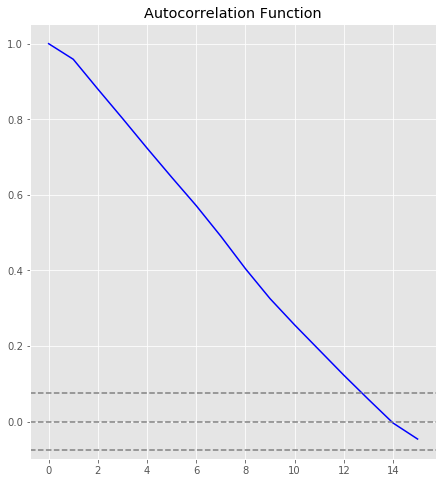

In [480]:
#Plot ACF:
plt.figure(figsize=(16, 8))
plt.subplot(121) 
plt.plot(lag_acf, color='b')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(shifted_data[shifted_data.index > '2016-01-01'].size),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(shifted_data[shifted_data.index > '2016-01-01'].size),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

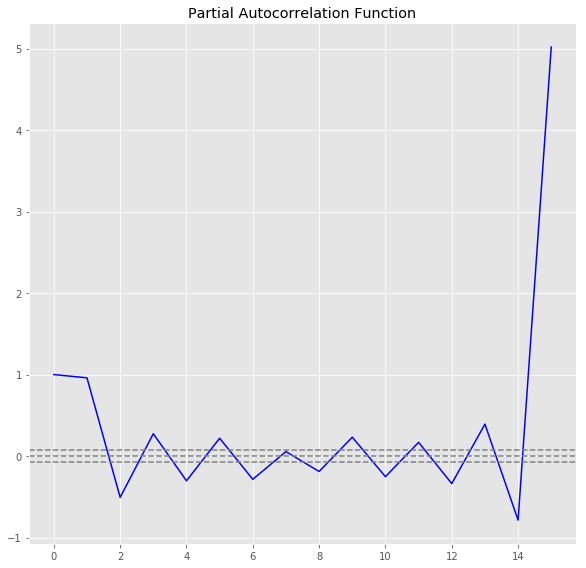

In [481]:
#Plot PACF:
plt.figure(figsize=(16, 8))
plt.subplot(122)
plt.plot(lag_pacf, color='b')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(shifted_data[shifted_data.index > '2016-01-01'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(shifted_data[shifted_data.index > '2016-01-01'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

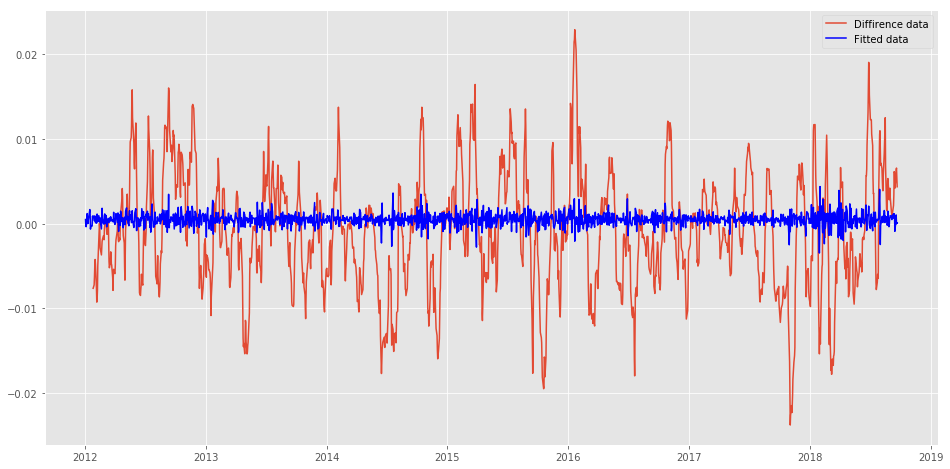

In [510]:
fig, ax = plt.subplots(1,1, figsize=(16,8))
model = sm.tsa.ARIMA(logts, order=(3, 1, 0))  
results_AR = model.fit(disp=-1)  
ax.plot(shifted_data, label="Diffirence data")
ax.plot(results_AR.fittedvalues, color='b', label="Fitted data")
ax.legend()

In [511]:
predictions_AR_diff = pd.Series(results_AR.fittedvalues, copy=True)
predictions_AR_diff.head()

Date
2012-01-04    0.000506
2012-01-05   -0.000320
2012-01-06   -0.000339
2012-01-09    0.001205
2012-01-10    0.000645
dtype: float64

In [512]:
predictions_AR_diff_cumsum = predictions_AR_diff.cumsum()
predictions_AR_diff_cumsum.head()

Date
2012-01-04    0.000506
2012-01-05    0.000186
2012-01-06   -0.000153
2012-01-09    0.001052
2012-01-10    0.001697
dtype: float64

In [513]:
predictions_AR_log = pd.Series(logts.ix[0], index=logts.index)
predictions_AR_log = predictions_AR_log.add(predictions_AR_diff_cumsum,fill_value=0)
np.exp(predictions_AR_log.tail())

Date
2018-09-17    46.568644
2018-09-18    46.617333
2018-09-19    46.617288
2018-09-20    46.623379
2018-09-21    46.628347
dtype: float64

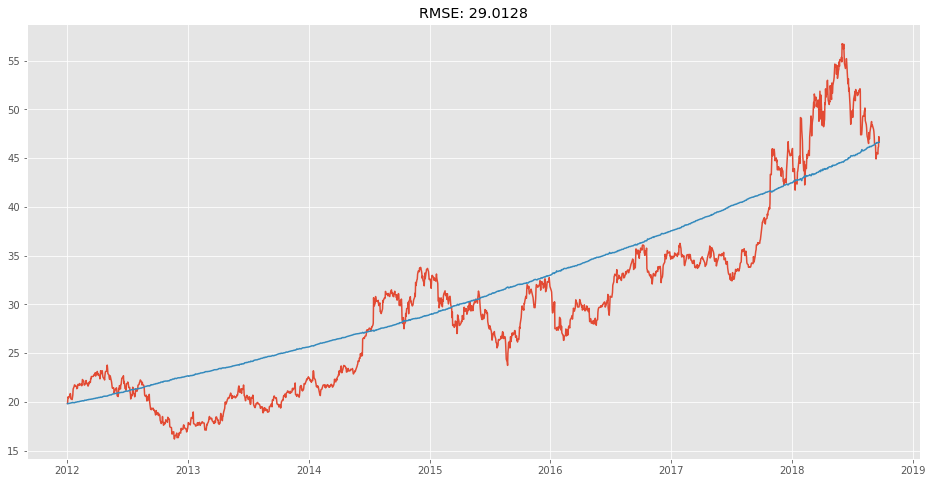

In [514]:
ARIMA_predict = np.exp(predictions_AR_log)
plt.figure(figsize=(16, 8))
plt.plot(intel['Adj Close'])
plt.plot(ARIMA_predict)
plt.title('RMSE: %.4f'% np.sqrt(sum((ARIMA_predict-logts)**2)/logts.size))

### Signal Fronter Analysis

In [515]:
# This originally included TSLA, but it was found to be too much of an outlier
## and did not plot well
stocks =["SBUX", "NKE", "JPM", "WMT", "GE", "INTC", "XOM", "IBKR"]

# Function to grab stock data from the web
def get_px(stock, start, end):
    return web.get_data_yahoo(stock, start, end)['Adj Close']

series = []
for stock in stocks:
    series.append(web.get_data_yahoo(stock, '2012-01-01', '2018-09-21')['Adj Close'])

pxdf = pd.concat(series, axis=1)
pxdf.columns = stocks
# Create a DataFrame for the range we are interested in
# spx = pd.DataFrame({n: get_px(n, '1/1/2012', '12/31/2016') for n in names})
# intelts = web.get_data_yahoo("INTC", '2012-01-01', '2018-09-21')['Adj Close']
# sp500ts = web.get_data_yahoo("SPY", '2012-01-01', '2018-09-21')['Adj Close']

In [516]:
pxdf.columns = stocks

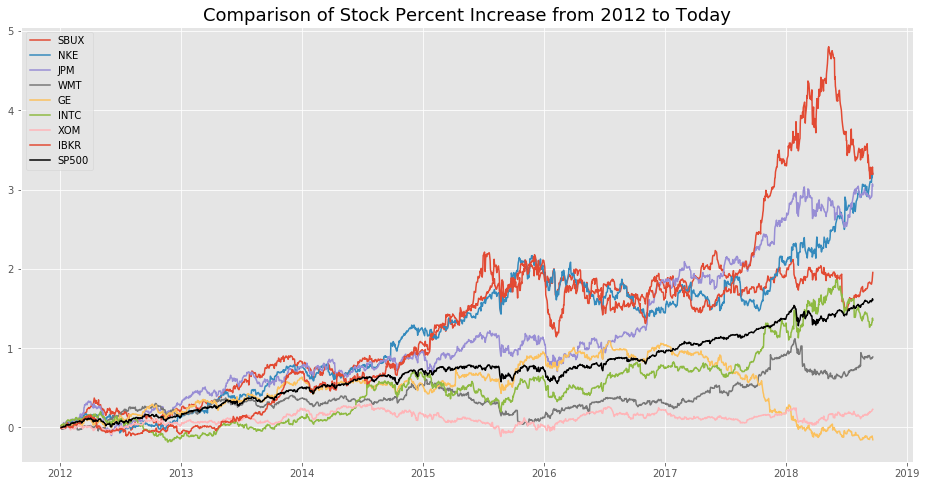

In [517]:
pxdf = pxdf.asfreq('B').fillna(method='pad')
rets = pxdf.pct_change()

px1 = ((1 + rets).cumprod() - 1).iloc[1:,:]
sp500ts = sp500ts.asfreq('B').fillna(method='pad')
rets = sp500ts.pct_change()
px2 = ((1 + rets).cumprod() - 1)

fig, ax = plt.subplots(1,1, figsize=(16,8))
for stock in stocks:
    ax.plot(px1[stock], label=stock)
ax.plot(px2, color='k', label="SP500")
ax.legend()
ax.set_title("Comparison of Stock Percent Increase from 2012 to Today", {'size': 18})


In [518]:
compound = lambda x : (1 + x).prod() - 1
daily_sr = lambda x: x.mean() / x.std()

def calc_mom(price, lookback, lag):
    mom_ret = price.shift(lag).pct_change(lookback)
    ranks = mom_ret.rank(axis=1, ascending=False)
    demeaned = ranks.subtract(ranks.mean(axis=1), axis=0)
    return demeaned.divide(demeaned.std(axis=1), axis=0)

def strat_sr(prices, lb, hold):
    # Compute portfolio weights
    freq = '%dB' % hold
    port = calc_mom(prices, lb, lag=1)
    daily_rets = prices.pct_change()
    # Compute portfolio returns
    port = port.shift(1).resample(freq).first()
    returns = daily_rets.resample(freq).apply(compound)
    port_rets = (port * returns).sum(axis=1)
    return daily_sr(port_rets) * np.sqrt(252 / hold)

In [519]:
from collections import defaultdict

lookbacks = range(20, 90, 5)
holdings = range(20, 90, 5)
dd = defaultdict(dict)
for lb in lookbacks:
    for hold in holdings:
        dd[lb][hold] = strat_sr(pxdf, lb, hold)

ddf = pd.DataFrame(dd)
ddf.index.name = 'Holding Period'
ddf.columns.name = 'Lookback Period'

In [520]:
def heatmap(df, cmap=plt.cm.RdYlGn):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111)
    axim = ax.imshow(df.values, cmap=cmap, interpolation='nearest')
    ax.set_xlabel(df.columns.name)
    ax.set_xticks(np.arange(len(df.columns)))
    ax.set_xticklabels(list(df.columns))
    ax.set_ylabel(df.index.name)
    ax.set_yticks(np.arange(len(df.index)))
    ax.set_yticklabels(list(df.index))
    plt.colorbar(axim)

Heatmap of momentum strategy Sharpe ratio (higher is better) over various lookbacks and holding periods.

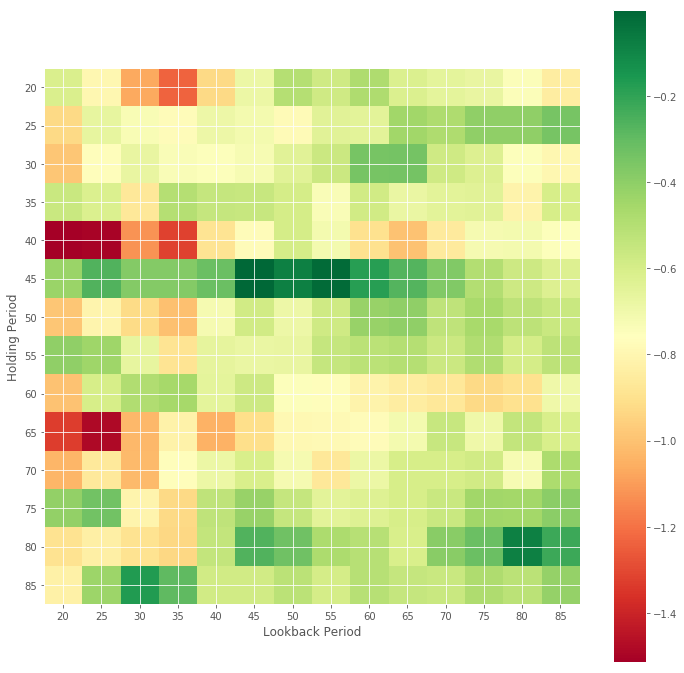

In [521]:
heatmap(ddf)

* It looks like the ideal Lookback/Holding Period is either 80/80, or 45/60

In [522]:
# Max total Sharpe Ratio
max_ratio =  max([ddf[i].max() for i in ddf.columns])
print("Max Sharpe Ratio is: {:.3f}".format(max_ratio))

Max Sharpe Ratio is: -0.001


In [524]:
ddf[ddf == max_ratio]

Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,NaN,NaN,NaN,NaN,NaN,-0.000537,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The max ratio of 2.38 is avaliable at a holding period of 45 and a lookback period of 50

In [525]:
# Max total Sharpe Ratio
min_ratio =  min([ddf[i].min() for i in ddf.columns])
print("Max Sharpe Ratio is: {:.3f}".format(min_ratio))

Max Sharpe Ratio is: -1.514


In [526]:
ddf[ddf == min_ratio]

Lookback Period,20,25,30,35,40,45,50,55,60,65,70,75,80,85
Holding Period,,,,,,,,,,,,,,
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,-1.51445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The Min Sharpe ratio of -1.55 is avaliable at a holding period of 40 and a lookback period of 20